<a href="https://colab.research.google.com/github/Hussein-Ahmad-94/Encoding_the_loss/blob/main/Three%2BModels%2BStacking_on_combined_loss%2BFeatures_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("train.csv", parse_dates=["Date"], index_col=[0])

# Train-test split
test_split = round(len(df) * 0.20)
df_for_training = df[:-test_split]
df_for_testing = df[-test_split:]

# One features

In [ ]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_1feature = scaler.fit_transform(df_for_training.iloc[:, :1])
df_for_testing_scaled_1feature = scaler.transform(df_for_testing.iloc[:, :1])

# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


In [ ]:
n_past = 30
trainX_1feature, trainY_1feature = createXY(df_for_training_scaled_1feature, n_past)
testX_1feature, testY_1feature = createXY(df_for_testing_scaled_1feature, n_past)

In [ ]:
# Function to plot training loss
def plot_training_loss(history, model_name):
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

# Function to train and evaluate the model
def train_and_evaluate_model(model, loss_function, train_data, train_labels, test_data, test_labels, epochs, batch_size):
    model.compile(optimizer=Adam(), loss=loss_function)
    start_time = time.time()
    history = model.fit(
        train_data, train_labels,
        epochs=epochs, batch_size=batch_size,
        validation_split=0.1, verbose=0
    )
    end_time = time.time()
    training_time = end_time - start_time
    final_loss = model.evaluate(test_data, test_labels)
    return final_loss, training_time, history

# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss

# Build and compile models
def build_model(loss_function):
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_past, 1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss=loss_function)
    return model

model1_1feature = build_model(custom_loss)
model2_1feature = build_model(custom_loss)

# Create a DataFrame to store results
results_df_1 = pd.DataFrame(columns=['Model', 'Final Loss', 'Training Time'])

# Define epochs and batch_size
epochs = 10
batch_size = 32

# Train and evaluate Model 1
final_loss1, training_time1, history1 = train_and_evaluate_model(
    model1_1feature, custom_loss, trainX_1feature, trainY_1feature, testX_1feature, testY_1feature, epochs, batch_size
)
print(f"Model 1 Final Loss: {final_loss1}, Training Time: {training_time1} seconds")


# Train and evaluate Model 2
final_loss2, training_time2, history2 = train_and_evaluate_model(
    model2_1feature, custom_loss, trainX_1feature, trainY_1feature, testX_1feature, testY_1feature, epochs, batch_size
)
print(f"Model 2 Final Loss: {final_loss2}, Training Time: {training_time2} seconds")


# Make predictions on the test set
pred1 = model1_1feature.predict(testX_1feature)
pred2 = model2_1feature.predict(testX_1feature)

# Combine losses for Model 1 and Model 2
loss1_1feature = model1_1feature.evaluate(testX_1feature, testY_1feature)
loss2_1feature = model2_1feature.evaluate(testX_1feature, testY_1feature)
combined_loss_1feature = (loss1_1feature + loss2_1feature) / 2
y_combined_loss_1feature = np.full((len(testY_1feature), 1), combined_loss_1feature)

# Concatenate predictions as features for the meta-model
stacked_features = np.concatenate([pred1, pred2], axis=1)

# Build and compile the meta-model with combined loss
meta_model = Sequential()
meta_model.add(Dense(64, activation='relu', input_shape=(stacked_features.shape[1],)))
meta_model.add(Dense(1))
meta_model.compile(optimizer=Adam(), loss=custom_loss)

# Train and evaluate the meta-model
meta_history = meta_model.fit(stacked_features, y_combined_loss_1feature, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2)
print(f"Meta-Model Final Loss: {meta_history.history['val_loss'][-1]}, Training Time: {np.sum(meta_history.epoch)} epochs")

# Append results to the DataFrame
results_df_1 = results_df_1.append({'Model': 'Model 1', 'Final Loss': final_loss1, 'Training Time': training_time1}, ignore_index=True)
results_df_1 = results_df_1.append({'Model': 'Model 2', 'Final Loss': final_loss2, 'Training Time': training_time2}, ignore_index=True)
results_df_1 = results_df_1.append({'Model': 'Meta-Model', 'Final Loss': meta_history.history['val_loss'][-1], 'Training Time': np.sum(meta_history.epoch)}, ignore_index=True)

# Display the results DataFrame
print(results_df_1)

32/32 [==============================] - 0s 5ms/step - loss: 1.4392e-04
Model 1 Final Loss: 0.00014392405864782631, Training Time: 23.788164377212524 seconds
32/32 [==============================] - 0s 7ms/step - loss: 1.8013e-04
Model 2 Final Loss: 0.0001801305916160345, Training Time: 20.10275173187256 seconds
32/32 [==============================] - 0s 5ms/step - loss: 1.8013e-04
Epoch 1/10
29/29 - 1s - loss: 7.6920e-05 - val_loss: 2.1682e-07 - 643ms/epoch - 22ms/step
Epoch 2/10
29/29 - 0s - loss: 3.8749e-06 - val_loss: 1.2470e-06 - 79ms/epoch - 3ms/step
Epoch 3/10
29/29 - 0s - loss: 3.1423e-07 - val_loss: 9.6096e-08 - 77ms/epoch - 3ms/step
Epoch 4/10
29/29 - 0s - loss: 6.1144e-08 - val_loss: 8.1174e-10 - 84ms/epoch - 3ms/step
Epoch 5/10
29/29 - 0s - loss: 2.4045e-08 - val_loss: 1.1404e-09 - 75ms/epoch - 3ms/step
Epoch 6/10
29/29 - 0s - loss: 1.2822e-08 - val_loss: 1.9736e-09 - 92ms/epoch - 3ms/step
Epoch 7/10
29/29 - 0s - loss: 9.2974e-09 - val_loss: 8.3319e-10 - 71ms/epoch - 2ms/s

<ipython-input-6-8e09c493ea10>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_1 = results_df_1.append({'Model': 'Model 1', 'Final Loss': final_loss1, 'Training Time': training_time1}, ignore_index=True)
<ipython-input-6-8e09c493ea10>:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_1 = results_df_1.append({'Model': 'Model 2', 'Final Loss': final_loss2, 'Training Time': training_time2}, ignore_index=True)
<ipython-input-6-8e09c493ea10>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_1 = results_df_1.append({'Model': 'Meta-Model', 'Final Loss': meta_history.history['val_loss'][-1], 'Training Time': np.sum(meta_history.epoch)}, ignore_index=True)


In [ ]:
# Display the results DataFrame
print(results_df_1)

        Model    Final Loss  Training Time
0     Model 1  1.439241e-04      23.788164
1     Model 2  1.801306e-04      20.102752
2  Meta-Model  7.446144e-10      45.000000


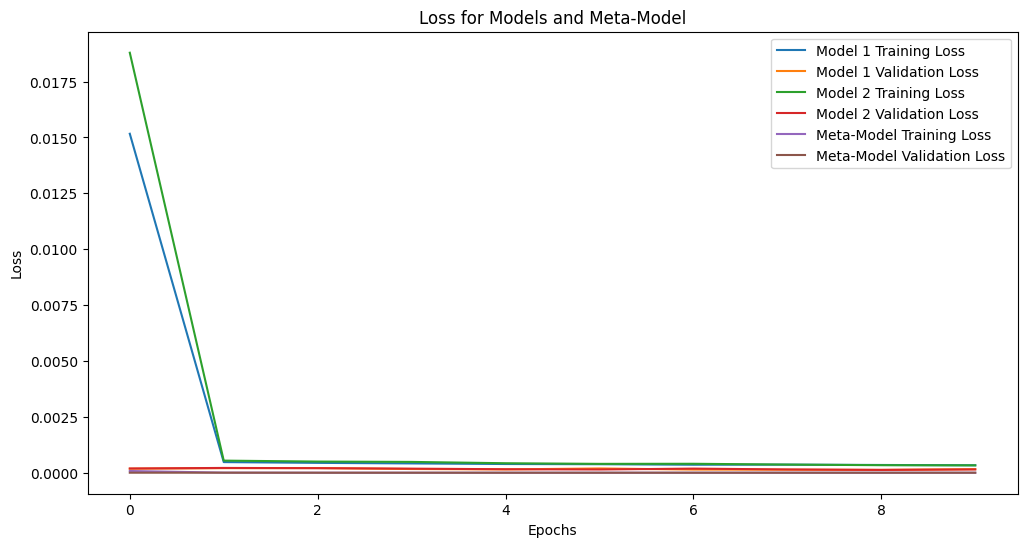

In [ ]:
# Plot the loss for each model and the meta-model
plt.figure(figsize=(12, 6))

# Model 1 loss
plot_training_loss(history1, 'Model 1')

# Model 2 loss
plot_training_loss(history2, 'Model 2')

# Meta-model loss
plt.plot(meta_history.history['loss'], label='Meta-Model Training Loss')
plt.plot(meta_history.history['val_loss'], label='Meta-Model Validation Loss')

plt.title('Loss for Models and Meta-Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

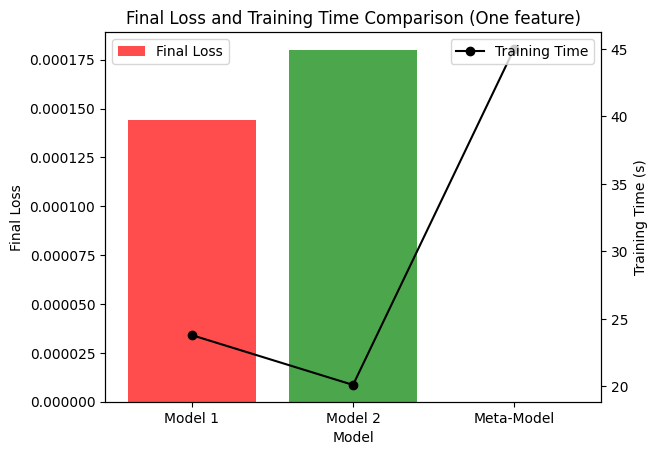

In [ ]:
# Plot a bar chart for the final testing loss and training time
fig, ax = plt.subplots()

# Plotting final loss
ax.bar(results_df_1['Model'], results_df_1['Final Loss'], color=['red', 'green', 'blue'], alpha=0.7, label='Final Loss')

# Adding training time as a line plot on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(results_df_1['Model'], results_df_1['Training Time'], color='black', marker='o', label='Training Time')

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Final Loss', color='black')
ax2.set_ylabel('Training Time (s)', color='black')
ax.set_title('Final Loss and Training Time Comparison (One feature)')

# Show legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


# Two features

In [ ]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_2feature = scaler.fit_transform(df_for_training.iloc[:, :2])
df_for_testing_scaled_2feature = scaler.transform(df_for_testing.iloc[:, :2])

# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


In [ ]:
n_past = 30
trainX_2feature, trainY_2feature = createXY(df_for_training_scaled_2feature, n_past)
testX_2feature, testY_2feature = createXY(df_for_testing_scaled_2feature, n_past)

In [ ]:
# Function to plot training loss
def plot_training_loss(history, model_name):
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

# Function to train and evaluate the model
def train_and_evaluate_model(model, loss_function, train_data, train_labels, test_data, test_labels, epochs, batch_size):
    model.compile(optimizer=Adam(), loss=loss_function)
    start_time = time.time()
    history = model.fit(
        train_data, train_labels,
        epochs=epochs, batch_size=batch_size,
        validation_split=0.1, verbose=0
    )
    end_time = time.time()
    training_time = end_time - start_time
    final_loss = model.evaluate(test_data, test_labels)
    return final_loss, training_time, history

# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss

# Build and compile models
def build_model(loss_function):
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_past, 2)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss=loss_function)
    return model

model1_2feature = build_model(custom_loss)
model2_2feature = build_model(custom_loss)

# Create a DataFrame to store results
results_df_2 = pd.DataFrame(columns=['Model', 'Final Loss', 'Training Time'])

# Define epochs and batch_size
epochs = 10
batch_size = 32

# Train and evaluate Model 1
final_loss1, training_time1, history1 = train_and_evaluate_model(
    model1_2feature, custom_loss, trainX_2feature, trainY_2feature, testX_2feature, testY_2feature, epochs, batch_size
)
print(f"Model 1 Final Loss: {final_loss1}, Training Time: {training_time1} seconds")


# Train and evaluate Model 2
final_loss2, training_time2, history2 = train_and_evaluate_model(
    model2_1feature, custom_loss, trainX_1feature, trainY_1feature, testX_1feature, testY_1feature, epochs, batch_size
)
print(f"Model 2 Final Loss: {final_loss2}, Training Time: {training_time2} seconds")


# Make predictions on the test set
pred1 = model1_2feature.predict(testX_2feature)
pred2 = model2_2feature.predict(testX_2feature)

# Combine losses for Model 1 and Model 2
loss1_2feature = model1_2feature.evaluate(testX_2feature, testY_2feature)
loss2_2feature = model2_2feature.evaluate(testX_2feature, testY_2feature)
combined_loss_2feature = (loss1_2feature + loss2_2feature) / 2
y_combined_loss_2feature = np.full((len(testY_1feature), 1), combined_loss_2feature)

# Concatenate predictions as features for the meta-model
stacked_features = np.concatenate([pred1, pred2], axis=1)

# Build and compile the meta-model with combined loss
meta_model = Sequential()
meta_model.add(Dense(64, activation='relu', input_shape=(stacked_features.shape[1],)))
meta_model.add(Dense(1))
meta_model.compile(optimizer=Adam(), loss=custom_loss)

# Train and evaluate the meta-model
meta_history = meta_model.fit(stacked_features, y_combined_loss_2feature, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2)
print(f"Meta-Model Final Loss: {meta_history.history['val_loss'][-1]}, Training Time: {np.sum(meta_history.epoch)} epochs")

# Append results to the DataFrame
results_df_2 = results_df_2.append({'Model': 'Model 1', 'Final Loss': final_loss1, 'Training Time': training_time1}, ignore_index=True)
results_df_2 = results_df_2.append({'Model': 'Model 2', 'Final Loss': final_loss2, 'Training Time': training_time2}, ignore_index=True)
results_df_2 = results_df_2.append({'Model': 'Meta-Model', 'Final Loss': meta_history.history['val_loss'][-1], 'Training Time': np.sum(meta_history.epoch)}, ignore_index=True)

# Display the results DataFrame
print(results_df_2)

32/32 [==============================] - 0s 6ms/step - loss: 1.5521e-04
Model 1 Final Loss: 0.00015520895249210298, Training Time: 22.93706464767456 seconds
32/32 [==============================] - 0s 8ms/step - loss: 8.2290e-05
Model 2 Final Loss: 8.228984370362014e-05, Training Time: 21.62010622024536 seconds
32/32 [==============================] - 1s 6ms/step - loss: 0.0137
Epoch 1/10
29/29 - 1s - loss: 7.3887e-05 - val_loss: 3.6508e-09 - 677ms/epoch - 23ms/step
Epoch 2/10
29/29 - 0s - loss: 8.0287e-07 - val_loss: 6.5330e-07 - 79ms/epoch - 3ms/step
Epoch 3/10
29/29 - 0s - loss: 1.3970e-07 - val_loss: 1.0640e-07 - 77ms/epoch - 3ms/step
Epoch 4/10
29/29 - 0s - loss: 7.6776e-08 - val_loss: 2.0048e-08 - 80ms/epoch - 3ms/step
Epoch 5/10
29/29 - 0s - loss: 5.3287e-08 - val_loss: 9.2791e-08 - 87ms/epoch - 3ms/step
Epoch 6/10
29/29 - 0s - loss: 4.6162e-08 - val_loss: 8.6394e-08 - 92ms/epoch - 3ms/step
Epoch 7/10
29/29 - 0s - loss: 3.7165e-08 - val_loss: 1.9144e-08 - 91ms/epoch - 3ms/step
E

<ipython-input-13-e227f476a098>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_2 = results_df_2.append({'Model': 'Model 1', 'Final Loss': final_loss1, 'Training Time': training_time1}, ignore_index=True)
<ipython-input-13-e227f476a098>:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_2 = results_df_2.append({'Model': 'Model 2', 'Final Loss': final_loss2, 'Training Time': training_time2}, ignore_index=True)
<ipython-input-13-e227f476a098>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_2 = results_df_2.append({'Model': 'Meta-Model', 'Final Loss': meta_history.history['val_loss'][-1], 'Training Time': np.sum(meta_history.epoch)}, ignore_index=True)


In [ ]:
# Display the results DataFrame
print(results_df_2)

        Model    Final Loss  Training Time
0     Model 1  1.552090e-04      22.937065
1     Model 2  8.228984e-05      21.620106
2  Meta-Model  2.444626e-08      45.000000


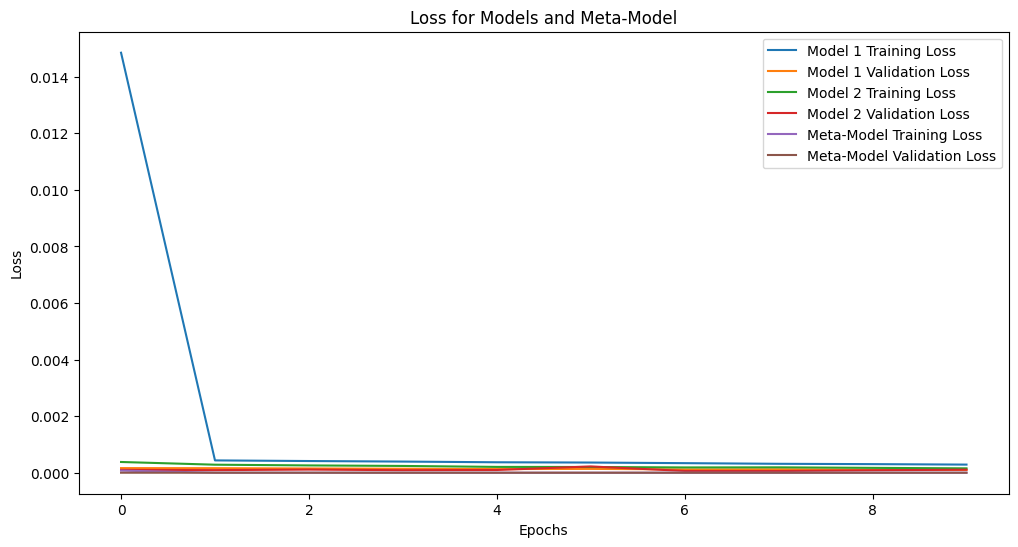

In [ ]:
# Plot the loss for each model and the meta-model
plt.figure(figsize=(12, 6))

# Model 1 loss
plot_training_loss(history1, 'Model 1')

# Model 2 loss
plot_training_loss(history2, 'Model 2')

# Meta-model loss
plt.plot(meta_history.history['loss'], label='Meta-Model Training Loss')
plt.plot(meta_history.history['val_loss'], label='Meta-Model Validation Loss')

plt.title('Loss for Models and Meta-Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

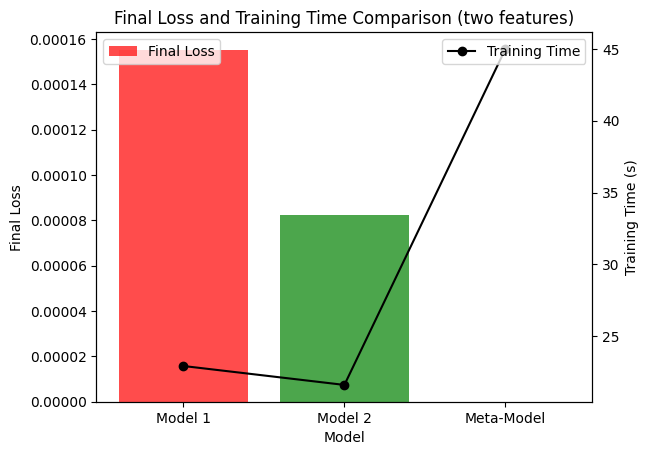

In [ ]:
# Plot a bar chart for the final testing loss and training time
fig, ax = plt.subplots()

# Plotting final loss
ax.bar(results_df_2['Model'],results_df_2['Final Loss'], color=['red', 'green', 'blue'], alpha=0.7, label='Final Loss')

# Adding training time as a line plot on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(results_df_2['Model'], results_df_2['Training Time'], color='black', marker='o', label='Training Time')

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Final Loss', color='black')
ax2.set_ylabel('Training Time (s)', color='black')
ax.set_title('Final Loss and Training Time Comparison (two features)')

# Show legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


# Three features

In [ ]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_3feature = scaler.fit_transform(df_for_training.iloc[:, :3])
df_for_testing_scaled_3feature = scaler.transform(df_for_testing.iloc[:, :3])

# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


In [ ]:
n_past = 30
trainX_3feature, trainY_3feature = createXY(df_for_training_scaled_3feature, n_past)
testX_3feature, testY_3feature = createXY(df_for_testing_scaled_3feature, n_past)


In [ ]:
# Function to plot training loss
def plot_training_loss(history, model_name):
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

# Function to train and evaluate the model
def train_and_evaluate_model(model, loss_function, train_data, train_labels, test_data, test_labels, epochs, batch_size):
    model.compile(optimizer=Adam(), loss=loss_function)
    start_time = time.time()
    history = model.fit(
        train_data, train_labels,
        epochs=epochs, batch_size=batch_size,
        validation_split=0.1, verbose=0
    )
    end_time = time.time()
    training_time = end_time - start_time
    final_loss = model.evaluate(test_data, test_labels)
    return final_loss, training_time, history

# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss

# Build and compile models for 3 features
def build_model_3feature(loss_function):
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_past, 3)))  # Adjust input shape for 3 features
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss=loss_function)
    return model

model1_3feature = build_model_3feature(custom_loss)
model2_3feature = build_model_3feature(custom_loss)

# Create a DataFrame to store results
results_df_3 = pd.DataFrame(columns=['Model', 'Final Loss', 'Training Time'])

# Train and evaluate Model 1 for 3 features
final_loss1_3feature, training_time1_3feature, history1_3feature = train_and_evaluate_model(
    model1_3feature, custom_loss, trainX_3feature, trainY_3feature, testX_3feature, testY_3feature, epochs, batch_size
)
print(f"Model 1 Final Loss: {final_loss1_3feature}, Training Time: {training_time1_3feature} seconds")

# Train and evaluate Model 2 for 3 features
final_loss2_3feature, training_time2_3feature, history2_3feature = train_and_evaluate_model(
    model2_3feature, custom_loss, trainX_3feature, trainY_3feature, testX_3feature, testY_3feature, epochs, batch_size
)
print(f"Model 2 Final Loss: {final_loss2_3feature}, Training Time: {training_time2_3feature} seconds")

# Make predictions on the test set for 3 features
pred1_3feature = model1_3feature.predict(testX_3feature)
pred2_3feature = model2_3feature.predict(testX_3feature)

# Combine losses for Model 1 and Model 2 for 3 features
loss1_3feature = model1_3feature.evaluate(testX_3feature, testY_3feature)
loss2_3feature = model2_3feature.evaluate(testX_3feature, testY_3feature)
combined_loss_3feature = (loss1_3feature + loss2_3feature) / 2
y_combined_loss_3feature = np.full((len(testY_3feature), 1), combined_loss_3feature)

# Concatenate predictions as features for the meta-model
stacked_features_3feature = np.concatenate([pred1_3feature, pred2_3feature], axis=1)

# Build and compile the meta-model with combined loss for 3 features
meta_model_3feature = Sequential()
meta_model_3feature.add(Dense(64, activation='relu', input_shape=(stacked_features_3feature.shape[1],)))
meta_model_3feature.add(Dense(1))
meta_model_3feature.compile(optimizer=Adam(), loss=custom_loss)

# Train and evaluate the meta-model for 3 features
meta_history_3feature = meta_model_3feature.fit(stacked_features_3feature, y_combined_loss_3feature, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2)
print(f"Meta-Model Final Loss: {meta_history_3feature.history['val_loss'][-1]}, Training Time: {np.sum(meta_history_3feature.epoch)} epochs")

# Append results to the DataFrame for 3 features
results_df_3 = results_df_3.append({'Model': 'Model 1', 'Final Loss': final_loss1_3feature, 'Training Time': training_time1_3feature}, ignore_index=True)
results_df_3 = results_df_3.append({'Model': 'Model 2', 'Final Loss': final_loss2_3feature, 'Training Time': training_time2_3feature}, ignore_index=True)
results_df_3 = results_df_3.append({'Model': 'Meta-Model', 'Final Loss': meta_history_3feature.history['val_loss'][-1], 'Training Time': np.sum(meta_history_3feature.epoch)}, ignore_index=True)

# Display the results DataFrame for 3 features
print(results_df_3)


32/32 [==============================] - 0s 6ms/step - loss: 1.2418e-04
Model 1 Final Loss: 0.00012418445840012282, Training Time: 23.087349891662598 seconds
32/32 [==============================] - 0s 7ms/step - loss: 1.7880e-04
Model 2 Final Loss: 0.00017880140512716025, Training Time: 43.95289754867554 seconds
32/32 [==============================] - 0s 9ms/step - loss: 1.7880e-04
Epoch 1/10
29/29 - 1s - loss: 2.6445e-04 - val_loss: 9.5314e-06 - 794ms/epoch - 27ms/step
Epoch 2/10
29/29 - 0s - loss: 6.8514e-06 - val_loss: 1.2156e-06 - 77ms/epoch - 3ms/step
Epoch 3/10
29/29 - 0s - loss: 1.0788e-06 - val_loss: 5.5735e-07 - 79ms/epoch - 3ms/step
Epoch 4/10
29/29 - 0s - loss: 3.7478e-07 - val_loss: 7.6956e-08 - 77ms/epoch - 3ms/step
Epoch 5/10
29/29 - 0s - loss: 1.8140e-07 - val_loss: 1.4226e-07 - 91ms/epoch - 3ms/step
Epoch 6/10
29/29 - 0s - loss: 1.2765e-07 - val_loss: 8.3437e-08 - 74ms/epoch - 3ms/step
Epoch 7/10
29/29 - 0s - loss: 9.9467e-08 - val_loss: 7.4711e-08 - 73ms/epoch - 3ms/

<ipython-input-21-5fca38f2ecf0>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_3 = results_df_3.append({'Model': 'Model 1', 'Final Loss': final_loss1_3feature, 'Training Time': training_time1_3feature}, ignore_index=True)
<ipython-input-21-5fca38f2ecf0>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_3 = results_df_3.append({'Model': 'Model 2', 'Final Loss': final_loss2_3feature, 'Training Time': training_time2_3feature}, ignore_index=True)
<ipython-input-21-5fca38f2ecf0>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_3 = results_df_3.append({'Model': 'Meta-Model', 'Final Loss': meta_history_3feature.history['val_loss'][-1], 'Training Time': np.sum(meta_history_3feature.epoch)}, igno

In [ ]:
# Display the results DataFrame
print(results_df_3)

        Model    Final Loss  Training Time
0     Model 1  1.241845e-04      23.087350
1     Model 2  1.788014e-04      43.952898
2  Meta-Model  8.090954e-09      45.000000


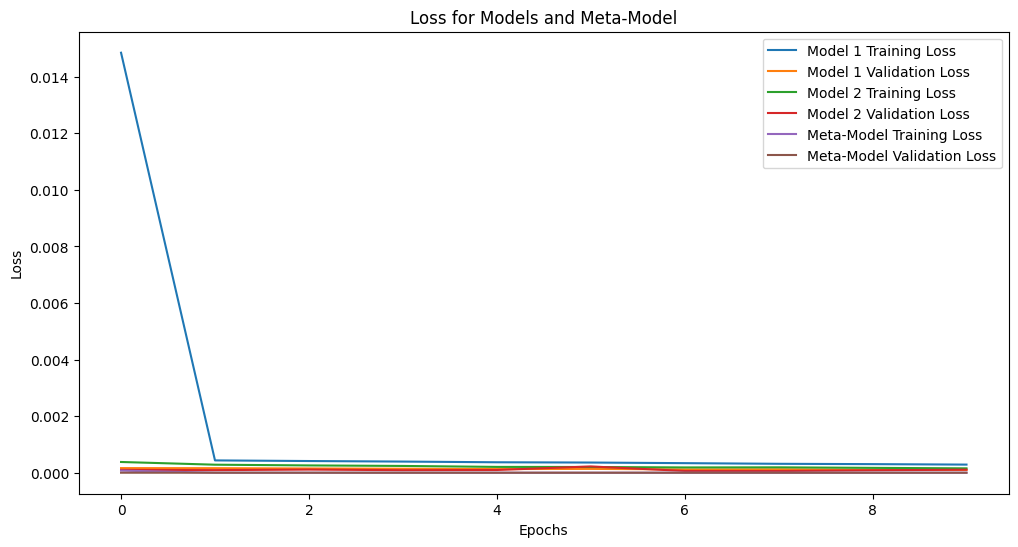

In [ ]:
# Plot the loss for each model and the meta-model
plt.figure(figsize=(12, 6))

# Model 1 loss
plot_training_loss(history1, 'Model 1')

# Model 2 loss
plot_training_loss(history2, 'Model 2')

# Meta-model loss
plt.plot(meta_history.history['loss'], label='Meta-Model Training Loss')
plt.plot(meta_history.history['val_loss'], label='Meta-Model Validation Loss')

plt.title('Loss for Models and Meta-Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

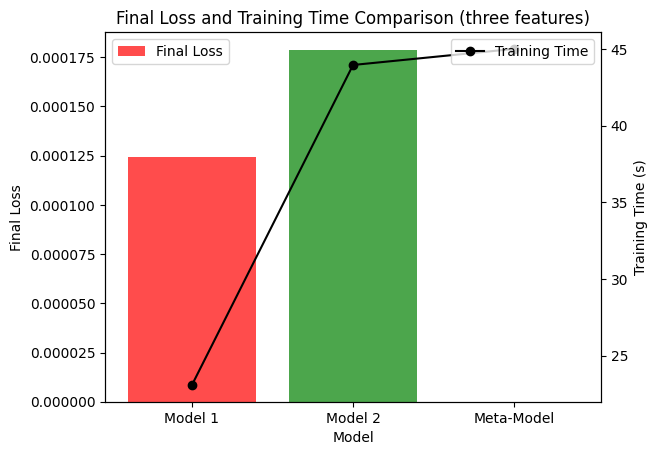

In [ ]:
# Plot a bar chart for the final testing loss and training time
fig, ax = plt.subplots()

# Plotting final loss
ax.bar(results_df_3['Model'], results_df_3['Final Loss'], color=['red', 'green', 'blue'], alpha=0.7, label='Final Loss')

# Adding training time as a line plot on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(results_df_3['Model'], results_df_3['Training Time'], color='black', marker='o', label='Training Time')

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Final Loss', color='black')
ax2.set_ylabel('Training Time (s)', color='black')
ax.set_title('Final Loss and Training Time Comparison (three features)')

# Show legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


# Four features

In [ ]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_4feature = scaler.fit_transform(df_for_training.iloc[:, :4])
df_for_testing_scaled_4feature = scaler.transform(df_for_testing.iloc[:, :4])

# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


In [ ]:
n_past = 30
trainX_4feature, trainY_4feature = createXY(df_for_training_scaled_4feature, n_past)
testX_4feature, testY_4feature = createXY(df_for_testing_scaled_4feature, n_past)

In [ ]:
# Function to plot training loss
def plot_training_loss(history, model_name):
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

# Function to train and evaluate the model
def train_and_evaluate_model(model, loss_function, train_data, train_labels, test_data, test_labels, epochs, batch_size):
    model.compile(optimizer=Adam(), loss=loss_function)
    start_time = time.time()
    history = model.fit(
        train_data, train_labels,
        epochs=epochs, batch_size=batch_size,
        validation_split=0.1, verbose=0
    )
    end_time = time.time()
    training_time = end_time - start_time
    final_loss = model.evaluate(test_data, test_labels)
    return final_loss, training_time, history

# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss

# Build and compile models for 4 features
def build_model_4feature(loss_function):
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_past, 4)))  # Adjust input shape for 4 features
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss=loss_function)
    return model

model1_4feature = build_model_4feature(custom_loss)
model2_4feature = build_model_4feature(custom_loss)

# Create a DataFrame to store results
results_df_4 = pd.DataFrame(columns=['Model', 'Final Loss', 'Training Time'])

# Train and evaluate Model 1 for 4 features
final_loss1_4feature, training_time1_4feature, history1_4feature = train_and_evaluate_model(
    model1_4feature, custom_loss, trainX_4feature, trainY_4feature, testX_4feature, testY_4feature, epochs, batch_size
)
print(f"Model 1 Final Loss: {final_loss1_4feature}, Training Time: {training_time1_4feature} seconds")

# Train and evaluate Model 2 for 4 features
final_loss2_4feature, training_time2_4feature, history2_4feature = train_and_evaluate_model(
    model2_4feature, custom_loss, trainX_4feature, trainY_4feature, testX_4feature, testY_4feature, epochs, batch_size
)
print(f"Model 2 Final Loss: {final_loss2_4feature}, Training Time: {training_time2_4feature} seconds")

# Make predictions on the test set for 4 features
pred1_4feature = model1_4feature.predict(testX_4feature)
pred2_4feature = model2_4feature.predict(testX_4feature)

# Combine losses for Model 1 and Model 2 for 4 features
loss1_4feature = model1_4feature.evaluate(testX_4feature, testY_4feature)
loss2_4feature = model2_4feature.evaluate(testX_4feature, testY_4feature)
combined_loss_4feature = (loss1_4feature + loss2_4feature) / 2
y_combined_loss_4feature = np.full((len(testY_4feature), 1), combined_loss_4feature)

# Concatenate predictions as features for the meta-model
stacked_features_4feature = np.concatenate([pred1_4feature, pred2_4feature], axis=1)

# Build and compile the meta-model with combined loss for 4 features
meta_model_4feature = Sequential()
meta_model_4feature.add(Dense(64, activation='relu', input_shape=(stacked_features_4feature.shape[1],)))
meta_model_4feature.add(Dense(1))
meta_model_4feature.compile(optimizer=Adam(), loss=custom_loss)

# Train and evaluate the meta-model for 4 features
meta_history_4feature = meta_model_4feature.fit(stacked_features_4feature, y_combined_loss_4feature, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2)
print(f"Meta-Model Final Loss: {meta_history_4feature.history['val_loss'][-1]}, Training Time: {np.sum(meta_history_4feature.epoch)} epochs")

# Append results to the DataFrame for 4 features
results_df_4 = results_df_4.append({'Model': 'Model 1', 'Final Loss': final_loss1_4feature, 'Training Time': training_time1_4feature}, ignore_index=True)
results_df_4 = results_df_4.append({'Model': 'Model 2', 'Final Loss': final_loss2_4feature, 'Training Time': training_time2_4feature}, ignore_index=True)
results_df_4 = results_df_4.append({'Model': 'Meta-Model', 'Final Loss': meta_history_4feature.history['val_loss'][-1], 'Training Time': np.sum(meta_history_4feature.epoch)}, ignore_index=True)

# Display the results DataFrame for 4 features
print(results_df_4)


32/32 [==============================] - 0s 5ms/step - loss: 8.2839e-05
Model 1 Final Loss: 8.283940405817702e-05, Training Time: 24.096473217010498 seconds
32/32 [==============================] - 0s 5ms/step - loss: 6.6266e-05
Model 2 Final Loss: 6.626560934819281e-05, Training Time: 27.32717537879944 seconds
32/32 [==============================] - 0s 6ms/step - loss: 6.6266e-05
Epoch 1/10
29/29 - 1s - loss: 3.7564e-06 - val_loss: 4.5910e-07 - 668ms/epoch - 23ms/step
Epoch 2/10
29/29 - 0s - loss: 1.1133e-07 - val_loss: 4.3484e-09 - 81ms/epoch - 3ms/step
Epoch 3/10
29/29 - 0s - loss: 8.3359e-09 - val_loss: 6.3242e-10 - 75ms/epoch - 3ms/step
Epoch 4/10
29/29 - 0s - loss: 2.8639e-09 - val_loss: 6.4130e-10 - 90ms/epoch - 3ms/step
Epoch 5/10
29/29 - 0s - loss: 2.0886e-09 - val_loss: 6.6364e-10 - 76ms/epoch - 3ms/step
Epoch 6/10
29/29 - 0s - loss: 1.7694e-09 - val_loss: 6.6119e-10 - 76ms/epoch - 3ms/step
Epoch 7/10
29/29 - 0s - loss: 1.8485e-09 - val_loss: 2.9950e-09 - 70ms/epoch - 2ms/st

<ipython-input-28-bbf1ff13e2fd>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_4 = results_df_4.append({'Model': 'Model 1', 'Final Loss': final_loss1_4feature, 'Training Time': training_time1_4feature}, ignore_index=True)
<ipython-input-28-bbf1ff13e2fd>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_4 = results_df_4.append({'Model': 'Model 2', 'Final Loss': final_loss2_4feature, 'Training Time': training_time2_4feature}, ignore_index=True)
<ipython-input-28-bbf1ff13e2fd>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_4 = results_df_4.append({'Model': 'Meta-Model', 'Final Loss': meta_history_4feature.history['val_loss'][-1], 'Training Time': np.sum(meta_history_4feature.epoch)}, igno

In [ ]:
# Display the results DataFrame
print(results_df_4)

        Model    Final Loss  Training Time
0     Model 1  8.283940e-05      24.096473
1     Model 2  6.626561e-05      27.327175
2  Meta-Model  1.493889e-09      45.000000


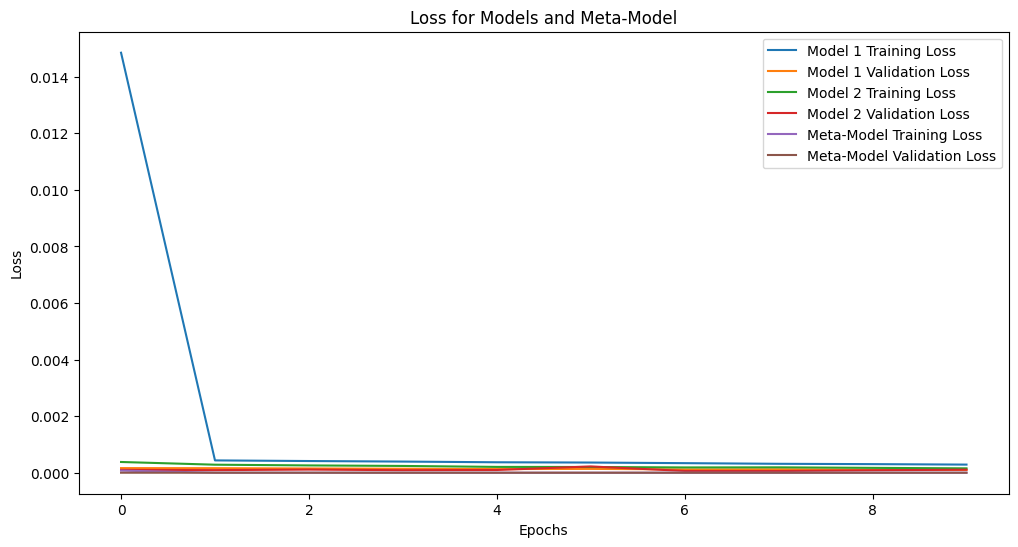

In [ ]:
# Plot the loss for each model and the meta-model
plt.figure(figsize=(12, 6))

# Model 1 loss
plot_training_loss(history1, 'Model 1')

# Model 2 loss
plot_training_loss(history2, 'Model 2')

# Meta-model loss
plt.plot(meta_history.history['loss'], label='Meta-Model Training Loss')
plt.plot(meta_history.history['val_loss'], label='Meta-Model Validation Loss')

plt.title('Loss for Models and Meta-Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

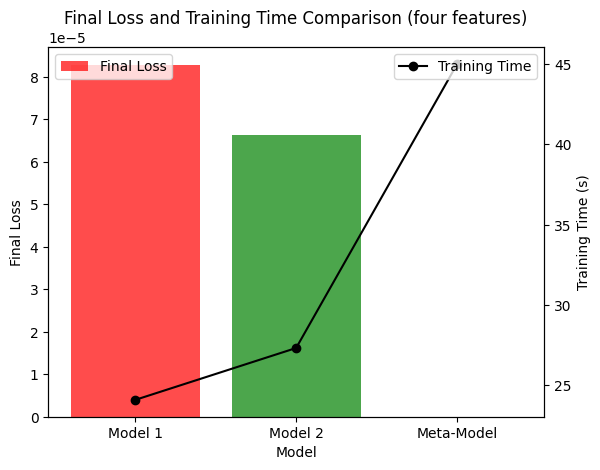

In [ ]:
# Plot a bar chart for the final testing loss and training time
fig, ax = plt.subplots()

# Plotting final loss
ax.bar(results_df_4['Model'], results_df_4['Final Loss'], color=['red', 'green', 'blue'], alpha=0.7, label='Final Loss')

# Adding training time as a line plot on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(results_df_4['Model'], results_df_4['Training Time'], color='black', marker='o', label='Training Time')

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Final Loss', color='black')
ax2.set_ylabel('Training Time (s)', color='black')
ax.set_title('Final Loss and Training Time Comparison (four features)')

# Show legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


# Fifth features

In [ ]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_5feature = scaler.fit_transform(df_for_training.iloc[:, :5])
df_for_testing_scaled_5feature = scaler.transform(df_for_testing.iloc[:, :5])

# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


In [ ]:
n_past = 30
trainX_5feature, trainY_5feature = createXY(df_for_training_scaled_5feature, n_past)
testX_5feature, testY_5feature = createXY(df_for_testing_scaled_5feature, n_past)

In [ ]:
# Function to plot training loss
def plot_training_loss(history, model_name):
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

# Function to train and evaluate the model
def train_and_evaluate_model(model, loss_function, train_data, train_labels, test_data, test_labels, epochs, batch_size):
    model.compile(optimizer=Adam(), loss=loss_function)
    start_time = time.time()
    history = model.fit(
        train_data, train_labels,
        epochs=epochs, batch_size=batch_size,
        validation_split=0.1, verbose=0
    )
    end_time = time.time()
    training_time = end_time - start_time
    final_loss = model.evaluate(test_data, test_labels)
    return final_loss, training_time, history

# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss

# Build and compile models for 5 features
def build_model_5feature(loss_function):
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_past, 5)))  # Adjust input shape for 5 features
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss=loss_function)
    return model

model1_5feature = build_model_5feature(custom_loss)
model2_5feature = build_model_5feature(custom_loss)

# Create a DataFrame to store results
results_df_5 = pd.DataFrame(columns=['Model', 'Final Loss', 'Training Time'])

# Define epochs and batch_size
epochs = 10
batch_size = 32

# Train and evaluate Model 1
final_loss1, training_time1, history1 = train_and_evaluate_model(
    model1_5feature, custom_loss, trainX_5feature, trainY_5feature, testX_5feature, testY_5feature, epochs, batch_size
)
print(f"Model 1 Final Loss: {final_loss1}, Training Time: {training_time1} seconds")

# Train and evaluate Model 2
final_loss2, training_time2, history2 = train_and_evaluate_model(
    model2_5feature, custom_loss, trainX_5feature, trainY_5feature, testX_5feature, testY_5feature, epochs, batch_size
)
print(f"Model 2 Final Loss: {final_loss2}, Training Time: {training_time2} seconds")

# Make predictions on the test set
pred1 = model1_5feature.predict(testX_5feature)
pred2 = model2_5feature.predict(testX_5feature)

# Combine losses for Model 1 and Model 2
loss1_5feature = model1_5feature.evaluate(testX_5feature, testY_5feature)
loss2_5feature = model2_5feature.evaluate(testX_5feature, testY_5feature)
combined_loss_5feature = (loss1_5feature + loss2_5feature) / 2
y_combined_loss_5feature = np.full((len(testY_5feature), 1), combined_loss_5feature)

# Concatenate predictions as features for the meta-model
stacked_features = np.concatenate([pred1, pred2], axis=1)

# Build and compile the meta-model with combined loss
meta_model = Sequential()
meta_model.add(Dense(64, activation='relu', input_shape=(stacked_features.shape[1],)))
meta_model.add(Dense(1))
meta_model.compile(optimizer=Adam(), loss=custom_loss)

# Train and evaluate the meta-model
meta_history = meta_model.fit(stacked_features, y_combined_loss_5feature, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2)
print(f"Meta-Model Final Loss: {meta_history.history['val_loss'][-1]}, Training Time: {np.sum(meta_history.epoch)} epochs")

# Append results to the DataFrame
results_df_5 = results_df_5.append({'Model': 'Model 1', 'Final Loss': final_loss1, 'Training Time': training_time1}, ignore_index=True)
results_df_5 = results_df_5.append({'Model': 'Model 2', 'Final Loss': final_loss2, 'Training Time': training_time2}, ignore_index=True)
results_df_5 = results_df_5.append({'Model': 'Meta-Model', 'Final Loss': meta_history.history['val_loss'][-1], 'Training Time': np.sum(meta_history.epoch)}, ignore_index=True)

# Display the results DataFrame
print(results_df_5)


32/32 [==============================] - 0s 6ms/step - loss: 6.9195e-05
Model 1 Final Loss: 6.91949826432392e-05, Training Time: 22.778125286102295 seconds
32/32 [==============================] - 0s 8ms/step - loss: 1.4565e-04
Model 2 Final Loss: 0.00014564799494110048, Training Time: 21.984934091567993 seconds
32/32 [==============================] - 0s 6ms/step - loss: 1.4565e-04
Epoch 1/10
29/29 - 1s - loss: 1.8069e-05 - val_loss: 4.3088e-06 - 718ms/epoch - 25ms/step
Epoch 2/10
29/29 - 0s - loss: 1.1794e-06 - val_loss: 6.3184e-08 - 101ms/epoch - 3ms/step
Epoch 3/10
29/29 - 0s - loss: 3.2288e-07 - val_loss: 1.0103e-07 - 101ms/epoch - 3ms/step
Epoch 4/10
29/29 - 0s - loss: 2.2424e-07 - val_loss: 5.2766e-08 - 95ms/epoch - 3ms/step
Epoch 5/10
29/29 - 0s - loss: 2.0973e-07 - val_loss: 9.2019e-08 - 76ms/epoch - 3ms/step
Epoch 6/10
29/29 - 0s - loss: 1.9416e-07 - val_loss: 5.2639e-08 - 80ms/epoch - 3ms/step
Epoch 7/10
29/29 - 0s - loss: 1.7628e-07 - val_loss: 5.9008e-08 - 79ms/epoch - 3ms

<ipython-input-34-200ad353a0b5>:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_5 = results_df_5.append({'Model': 'Model 1', 'Final Loss': final_loss1, 'Training Time': training_time1}, ignore_index=True)
<ipython-input-34-200ad353a0b5>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_5 = results_df_5.append({'Model': 'Model 2', 'Final Loss': final_loss2, 'Training Time': training_time2}, ignore_index=True)
<ipython-input-34-200ad353a0b5>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_5 = results_df_5.append({'Model': 'Meta-Model', 'Final Loss': meta_history.history['val_loss'][-1], 'Training Time': np.sum(meta_history.epoch)}, ignore_index=True)


In [ ]:
# Display the results DataFrame
print(results_df_5)

        Model    Final Loss  Training Time
0     Model 1  6.919498e-05      22.778125
1     Model 2  1.456480e-04      21.984934
2  Meta-Model  1.736988e-07      45.000000


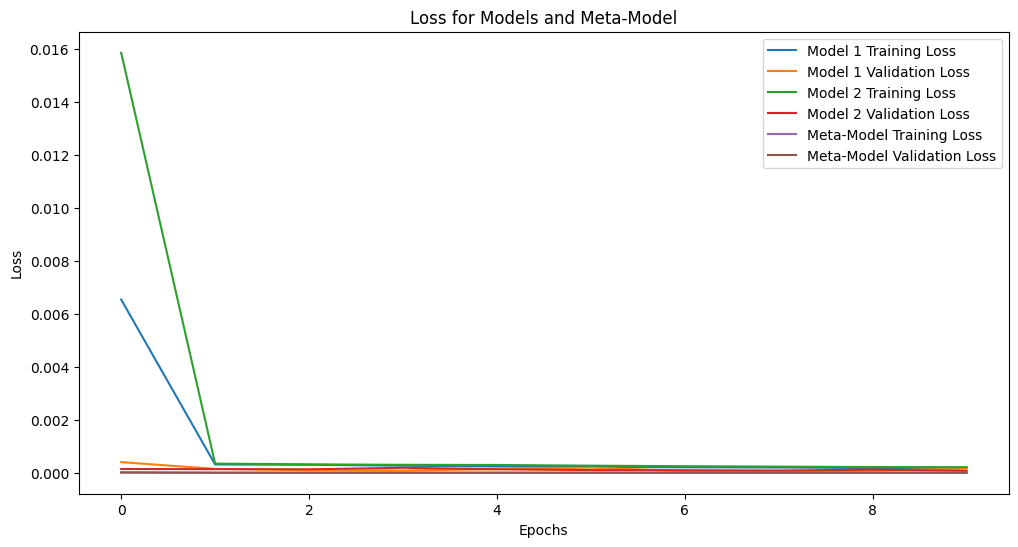

In [ ]:
# Plot the loss for each model and the meta-model
plt.figure(figsize=(12, 6))

# Model 1 loss
plot_training_loss(history1, 'Model 1')

# Model 2 loss
plot_training_loss(history2, 'Model 2')

# Meta-model loss
plt.plot(meta_history.history['loss'], label='Meta-Model Training Loss')
plt.plot(meta_history.history['val_loss'], label='Meta-Model Validation Loss')

plt.title('Loss for Models and Meta-Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

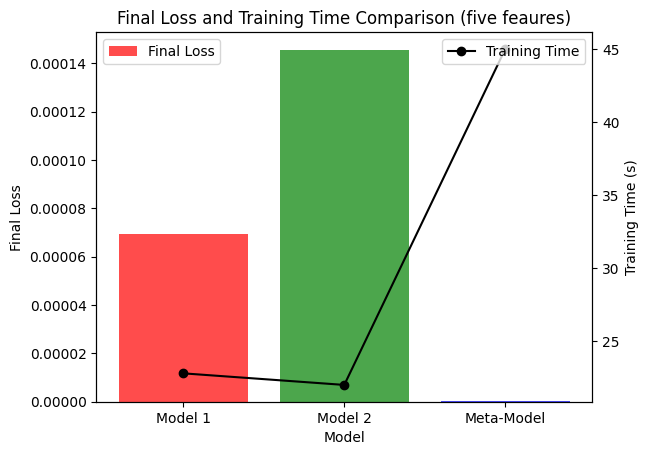

In [ ]:
# Plot a bar chart for the final testing loss and training time
fig, ax = plt.subplots()

# Plotting final loss
ax.bar(results_df_5['Model'], results_df_5['Final Loss'], color=['red', 'green', 'blue'], alpha=0.7, label='Final Loss')

# Adding training time as a line plot on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(results_df_5['Model'], results_df_5['Training Time'], color='black', marker='o', label='Training Time')

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Final Loss', color='black')
ax2.set_ylabel('Training Time (s)', color='black')
ax.set_title('Final Loss and Training Time Comparison (five feaures)')

# Show legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
